# Developing scripts to test different connectivity schemes

In [4]:
import jax
import math
import jax.numpy as jnp
import optax
import flax
from flax import nnx
from flax.nnx.nn import initializers
from typing import Callable
import orbax.checkpoint as ocp
import json
import os
import pickle
import numpy as np
from collections import defaultdict
from functools import partial

# from PseudoMLP import PseudoMLP
from utils import clipping_ste, intercore_connectivity, plot_connectivity_matrix

import tensorflow_datasets as tfds  # TFDS to download MNIST.
import tensorflow as tf  # TensorFlow / `tf.data` operations.
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import get_cmap
import seaborn as sns

%load_ext autoreload
%autoreload 2

2025-05-06 18:23:55.210924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746581035.224186  211484 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746581035.228203  211484 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Define intercore-connectivity function

In [2]:
# define a function to return a tensor with connectivity constraints
def intercore_connectivity(
    input_cores: int,
    output_cores: int,
    slots_per_core: int,
    avg_slot_connectivity: int,
    key: jax.random.key,
    ):

    """
    Returns a tensor C with shape (input_cores, total_input_slots, output_cores, total_output_slots).
    C[ci, si, co, so] can be [-2, -1, 0, 1, 2].
    1: connection to positive slots
    -1: connection to negative slots
    0: no connection
    -2: rare but repeated connection to negative slot
    2: rare but repeated connection to positive slot
    """

    # define the constants
    total_input_slots = input_cores * slots_per_core
    total_output_slots = output_cores * slots_per_core

    # define the lists of (core, slot) tuples
    Li = [(ci, si) for ci in range(input_cores) for si in range(slots_per_core)]
    Lo = [(co, so) for co in range(output_cores) for so in range(slots_per_core)]
    assert len(Li) == total_input_slots, "Incorrect number of input slots, check input_cores and slots_per_core values"
    assert len(Lo) == total_output_slots, "Incorrect number of output slots, check output_cores and slots_per_core values"
    
    # print(Li)
    # print(Lo)

    # define the positive and negative mapping dicts
    pos_mapping = defaultdict(list)
    neg_mapping = defaultdict(list)

    # construct the positive mapping
    for (co, so) in Lo:
        

        # pick a random number of slots it can receive input from
        key, subkey = jax.random.split(key)
        beta = jax.random.poisson(key=key, lam=avg_slot_connectivity)

        # pick random slots from Li
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key=key, a=len(Li), shape=(beta,), replace=True) # allow for repeated connections
        connections = [Li[i] for i in idx]
        if beta > 0:
            pos_mapping[(co, so)] = connections
        else:
            pos_mapping[(co, so)] = []


    print(f"Positive mapping: {pos_mapping}")

    # construct the negative mapping
    for k, v in pos_mapping.items():
        (co, so) = k
        # check if there are any connections
        if len(v) == 0:
            continue
        else:
            # print(v, len(v))
            for ti in v:
                # print(ti)
                # choose some slots where negative connections can be made
                key, subkey = jax.random.split(key)
                gamma = jax.random.choice(key=key, a=slots_per_core, shape=(1,), replace=True)[0].item()
                neg_mapping[ti].append((co, gamma))

    print(f"Negative mapping: {neg_mapping}")

    # construct the tensor for positive mappings
    C = jnp.zeros((input_cores, slots_per_core, output_cores, slots_per_core))

    for k, v in pos_mapping.items():
        (co, so) = k

        for ti in v:
            (ci, si) = ti
            C = C.at[ci, si, co, so].add(1)

    # construct the tensor for negative mappings
    for k, v in neg_mapping.items():
        (ci, si) = k

        if len(v) == 0:
            print(f"zero -ve mappings from core {k}")
            continue
        else:
            for to in v:
                (co, so) = to
                C = C.at[ci, si, co, so].add(-1)

    return C




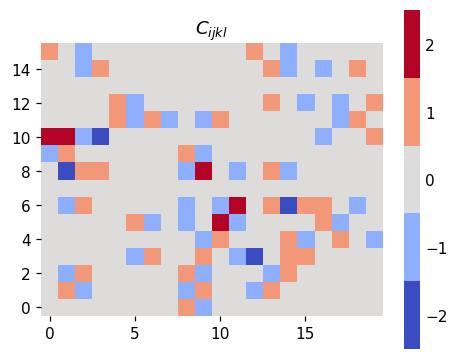

In [2]:
key = jax.random.key(20)
key, subkey = jax.random.split(key)
test_run = intercore_connectivity(input_cores = 4, output_cores = 5, slots_per_core = 4, avg_slot_connectivity=4, key=key)

# plotting
data = test_run.reshape(4*4, 5*4)

# Define the discrete values and boundaries
values = np.array([-2, -1, 0, 1, 2])
bounds = np.array([-2.5, -1.5, -0.5, 0.5, 1.5, 2.5])  # Boundaries for the colormap

# Create a colormap with 5 colors from the coolwarm colormap
base_cmap = plt.colormaps['coolwarm']
colors = base_cmap(np.linspace(0, 1, 5))
cmap = ListedColormap(colors)

# Create a norm to map the data values to colormap indices
norm = BoundaryNorm(bounds, cmap.N)

# Create the plot
fig, ax = plt.subplots(figsize=(5, 5), dpi=110)
ax.set_title(r"$C_{ijkl}$")
im = ax.imshow(data, cmap=cmap, norm=norm, interpolation='nearest', origin='lower')

# Add a colorbar
cbar = plt.colorbar(im, ticks=values, shrink=0.8)
# cbar.set_label('Connection Type')
cbar.outline.set_visible(False)
cbar.ax.tick_params(which='both', length=0, width=0, pad=3)
cbar.ax.minorticks_off() 

# Remove the spines from the colorbar

sns.despine(fig, top=True, right=True, left=True, bottom=True)


balanced!


(array([0., 0., 5., 0., 0.]),
 array([-0.5       , -0.30000001, -0.09999999,  0.10000002,  0.30000001,
         0.5       ]),
 <BarContainer object of 5 artists>)

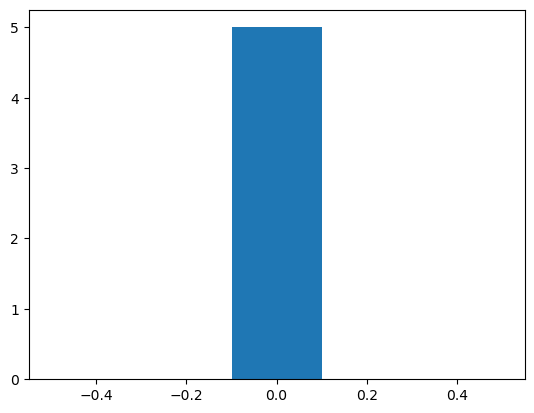

In [ ]:
def verify_connectivity(C):
    """
    Verify if the connectivity matrix makes sense
    - Each core must have equal number of positive and negative connections on an average
    - Returs a distribution of connections per core.
    - Distribution should be a delta zero with ideally no outliers
    """

    assert len(C.shape) == 4, "C must be a 4D tensor"

    balance_list = []

    # check for cores taking inputs
    for co in range(C.shape[2]):
        conn = jnp.sum(C[:, :, co, :])
        balance_list.append(conn)

    perc = jnp.percentile(a=jnp.array(balance_list), q=95)
    if perc == 0:
        print("Balanced!")
    else:
        print("Unbalanced")

    return balance_list


balance_list = verify_connectivity(test_run)
plt.hist(balance_list, bins=5)

In [5]:
# test input
key = jax.random.key(20)
key, subkey = jax.random.split(key)
x_test = jax.random.normal(key=subkey, shape=(1024,))
test_cores = 4
test_slots_per_core = 4
test_slot_length = 64
test_output_cores = 6
test_slot_conn = 4

x_test = x_test.reshape(test_cores, test_slots_per_core, test_slot_length)
print(x_test.shape)

key, subkey = jax.random.split(key)

C_test = intercore_connectivity(
    input_cores=test_cores,
    output_cores=test_output_cores,
    slots_per_core=test_slots_per_core,
    avg_slot_connectivity=test_slot_conn,
    key=key
)

print(C_test.shape)

out = jnp.einsum('ijkl,ijm->klm', C_test, x_test)
print(out.shape)

out = clipping_ste(out, threshold=0.0, noise_sd = 0.01, key=key)

key, subkey = jax.random.split(key)
W_test = jax.random.normal(key=key, shape=(test_output_cores, test_slots_per_core, test_slot_length, test_slot_length))
print(W_test.shape)

out = jnp.einsum('ijkl,ijl->ijk', W_test, out)
print(out.shape)
print(out[0, 0, :])

(4, 4, 64)
(4, 4, 6, 4)
(6, 4, 64)
(6, 4, 64, 64)
(6, 4, 64)
[ -1.4402864    2.0831676   -1.887496     0.66762304   0.859916
   1.204454    -2.9054615    4.8994584   -1.3893751    6.029047
   0.33366203  -2.2601783    0.6451092    1.2202469   -1.1536865
  -5.8391304    2.2267952    2.314348     5.8821607   -3.0623665
   4.4884853    0.57892656   7.0326204   -6.084094    -6.793433
  -8.753721     0.38281083   0.90840673  -0.18289518   2.1092846
   6.338797    -7.4819136   -2.475282    -1.9258767    1.1770213
   0.85030866   0.25778687  -1.8279357   13.9782715   -5.6661525
  -3.427627    -2.8160527    2.405257    -0.70410585   6.213415
  -1.1505599   -7.7014465   -4.911399     2.0272357   -0.6439328
   1.341508     0.51154613   4.536511     2.3835897   -1.3591142
  -1.4055109    1.1101446   -3.8881602  -16.335676    -0.62687063
   4.9475026    2.7966905   17.713144    -1.1374357 ]


# Defining a layer module

In [5]:
class ScRRAMBLeLayer(nnx.Module):
    """
    Experimental ScRRAMBLe Layer.
    - Defines trainable weights for every core.
    - The weights are organized into input a ouput layers which an be mapped onto cores.
    - Input is assumed to be flattened and will be reshaped inside the module to be fed into correct slots.
    
    Args:

    """

    def __init__(
        self,
        input_vector_size: int,
        input_cores: int,
        output_cores: int,
        avg_slot_connectivity: int, 
        slots_per_core: int,
        slot_length: int,
        activation: Callable,
        rngs: nnx.Rngs,
        core_length: int = 256


    ):

        self.core_length = core_length
        self.input_vector_size = input_vector_size
        self.input_eff_cores = self.input_vector_size//core_length
        self.input_cores = input_cores
        self.output_cores = output_cores
        self.avg_slot_connectivity = avg_slot_connectivity
        self.slots_per_core = slots_per_core
        self.slot_length = slot_length
        self.activation = activation
        self.rngs = rngs
        self.activation = partial(self.activation, threshold=0.0, noise_sd=0.05, key=self.rngs.activation())

        # define weights for input cores
        initializer = initializers.glorot_normal()
        self.Wi = nnx.Param(initializer(self.rngs.params(), (self.input_cores, self.slots_per_core, self.slot_length, self.slot_length)))

        # define output weights
        self.Wo = nnx.Param(initializer(self.rngs.params(), (self.output_cores, self.slots_per_core, self.slot_length, self.slot_length)))

        # define connectivity matrix between input vector and input cores: we can trat input as if it came from a layer of cores
        Ci = intercore_connectivity(
            input_cores=self.input_eff_cores,
            output_cores=self.input_cores,
            slots_per_core=self.slots_per_core,
            avg_slot_connectivity=self.avg_slot_connectivity,
            key=self.rngs.params()
        )

        self.Ci = nnx.Variable(Ci) 

        # define connectivity matrix between input and output cores
        C_cores = intercore_connectivity(
            input_cores=self.input_cores,
            output_cores=self.output_cores,
            slots_per_core=self.slots_per_core,
            avg_slot_connectivity=self.avg_slot_connectivity,
            key=self.rngs.params()
        )

        self.C_cores = nnx.Variable(C_cores)

    def __call__(self, x):
        # reshape the input
        x = x.reshape(self.input_eff_cores, self.slots_per_core, self.slot_length)

        # reconstruct the scrambled input
        x = jnp.einsum('ijkl,ijm->klm', self.Ci, x)

        # Feed this into the first set of cores
        y1 = jnp.einsum('ijkl,ijl->ijk', self.Wi, x)

        # apply the non-linearity
        y1 = self.activation(y1)

        # scramble the input to cores in layers l
        y1 = jnp.einsum('ijkl,ijm->klm', self.C_cores, y1)

        # feed the scrambled input into the set of cores in layer l
        y2 = jnp.einsum('ijkl,ijl->ijk', self.Wo, y1)

        # apply the non-linearity

        return self.activation(y2)



In [4]:
# testing the ScRRAMBLe layer
rngs = nnx.Rngs(params=1, activation=2)
x_test = jax.random.normal(key=rngs.params(), shape=(512,))

test_layer = ScRRAMBLeLayer(
    input_vector_size=x_test.shape[0],
    input_cores=5,
    output_cores=4,
    avg_slot_connectivity=4,
    slots_per_core=4,
    slot_length=64,
    rngs=rngs,
    activation=clipping_ste
)

nnx.display(test_layer)

test_out = test_layer(x_test)
print(test_out.shape)
print(test_out[0, 0, :])

(4, 4, 64)
[1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1.
 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0.
 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0.]


In [21]:
# define a batched version of the ScRRAMBLe layer
class BatchedScRRAMBLe(nnx.Module):
    """
    Wrapper around the ScRRAMBLe layer to allow for batched inputs.
    """

    def __init__(self, **kwargs):
        self.layer = ScRRAMBLeLayer(**kwargs)

    def __call__(self, x):
        """
        Forward pass with nnx.vmap for batched inputs.
        """

        out = nnx.vmap(self.layer)(x)
        out = out.reshape(-1, 4)
        out = jnp.average(out, axis=0)
        print(out.shape)
            
        return out

In [6]:
# define a population coding module
class ScRRAMBLeClassifier(nnx.Module):
    """
    Test module with population coding.
    """
    def __init__(self, population_coding: bool, group_size: int, **kwargs):
        self.scrramble_layer = ScRRAMBLeLayer(**kwargs)
        self.population_coding = population_coding
        self.group_size = group_size

    def __call__(self, x):

        out = nnx.vmap(self.scrramble_layer, in_axes=0, out_axes=0)(x) # apply vmap across the batch dimension

        if self.population_coding:
            # flatten the output
            flat_out = out.reshape(out.shape[0], -1)

            # truncate the output so that final dimension is divisible by the group size
            chunk_size = math.floor(flat_out.shape[1]/self.group_size)
            flat_out = flat_out[:, :chunk_size*self.group_size]

            # reshape to average 
            out_res = flat_out.reshape(flat_out.shape[0], self.group_size, -1)

            out = jnp.mean(out_res, axis=-1)
             
            return out
        else:
            out = nnx.vmap(self.scrramble_layer, in_axes=0, out_axes=0)(x)
            return out

(10, 4)


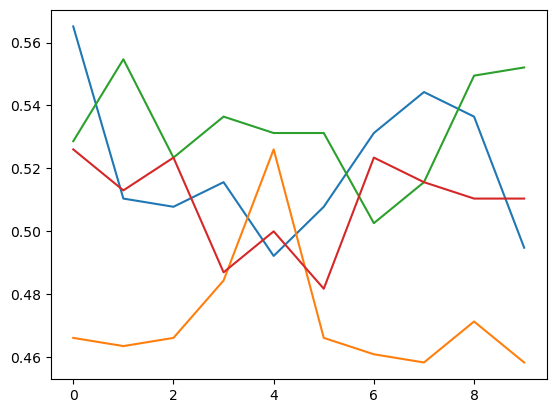

In [7]:
# test the population coding module
rngs = nnx.Rngs(params=1, activation=2)
x_test = jax.random.normal(key=rngs.params(), shape=(10, 512))


pop_coding_layer = ScRRAMBLeClassifier(
    population_coding=True,
    group_size=4,
    input_vector_size=512,
    input_cores=4,
    output_cores=6,
    avg_slot_connectivity=4,
    slots_per_core=4,
    slot_length=64,
    activation=clipping_ste,
    rngs=rngs
)

nnx.display(pop_coding_layer)
test_out = pop_coding_layer(x_test)

print(test_out.shape)
plt.plot(test_out)


In [22]:
# test batched ScRRAMBLe layer
xb_test = jax.random.normal(key=rngs.params(), shape=(10, 512))
batched_test_layer = BatchedScRRAMBLe(
    input_vector_size=xb_test.shape[1],
    input_cores=5,
    output_cores=4,
    avg_slot_connectivity=4,
    slots_per_core=4,
    slot_length=64,
    rngs=rngs,
    activation=clipping_ste
)
nnx.display(batched_test_layer)
batched_test_out = batched_test_layer(xb_test)
print(batched_test_out.shape)
# plt.imshow(batched_test_out[0, ...].reshape(16, -1), cmap='Grays', vmin=0, vmax=1.01)
# print(batched_test_out[0, 0, :])

(4,)
(4,)


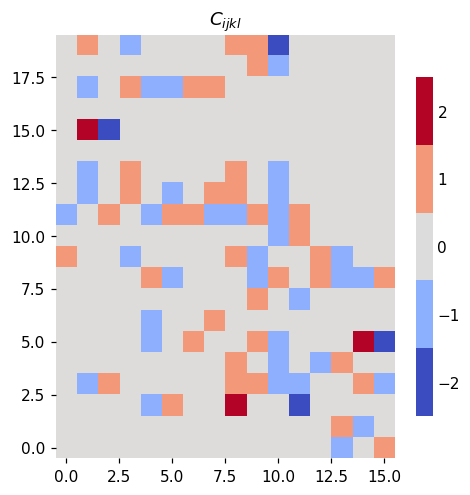

In [8]:
fig, ax = plot_connectivity_matrix(batched_test_layer.layer.C_cores.value)

## Define a toy dataset

In [2]:
def create_classification_dataset(
    n_samples: int,
    n_features: int,
    n_classes: int,
    n_informative: int,
    random_seed: int = 101,
    test_size: float = 0.2,
    binarize: bool = True

    ):

    """
    Create a synthetic classification dataset using sklearn.
    """

    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_classes=n_classes,
        n_informative=n_informative,
        random_state=random_seed
    )

    # binarize
    if binarize:
        X = jnp.where(X>0.0, 1.0, 0.0)


    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)

    return X_train, y_train, X_test, y_test

# create a batch iterator
def batch_iterator(X, y, rngs, batch_size):
    """
    Create a batch iterator for the dataset
    """

    # permute the dataset
    perm = jax.random.permutation(rngs.permute(), X.shape[0])
    X = X[perm]
    y = y[perm]

    # find number of steps in an epoch
    steps_per_epoch = X.shape[0]//batch_size

    for i in range(steps_per_epoch):
        start_idx = i*batch_size
        end_idx = start_idx + batch_size

        yield X[start_idx:end_idx], y[start_idx:end_idx]

    # TODO : add a final batch with the remaining samples


# testing
# X_train, y_train, X_test, y_test = create_classification_dataset(
#     n_samples=1000,
#     n_features=512,
#     n_classes=2,
#     n_informative=10,
# )

# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)
# # check the data
# print(X_train[0, :5])
# print(y_train[0])
# print(X_test[0, :5])
# print(y_test[0])


## Define training pipeline

In [10]:
def loss_fn(model, batch_input, batch_labels):
    """
    Define the loss function for the model.
    """

    logits = model(batch_input)
    print(logits.shape, batch_labels.shape)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch_labels).mean()

    return loss, logits

@nnx.jit
def train_step(
    model: ScRRAMBLeClassifier,
    optimizer: nnx.Optimizer,
    metrics: nnx.MultiMetric,
    batch_input: jax.Array,
    batch_labels: jax.Array
    ):

    """
    Training for a single step
    """

    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(model, batch)
    metrics.update(loss=loss, logits=logits, labels=batch_labels)
    optimizer.update(grads)


@nnx.jit
def eval_step(
    model: ScRRAMBLeClassifier,
    batch_input: jax.Array,
    batch_labels: jax.Array
    ):

    """
    Evaluation for a single step
    """

    loss, logits = loss_fn(model, batch_input, batch_labels)
    metrics.update(loss=loss, logits=logits, labels=batch_labels)

# testing the loss function
# loss, logits = loss_fn(pop_coding_layer, X_train[:100, :], y_train[:100])
# print(loss, logits)

In [ ]:
# define a training pipeline

arch_dict = {
    'input_vector_size' : 512,
    'input_cores' : 4,
    'output_cores' : 6,
    'avg_slot_connectivity' : 4,
    'slots_per_core' : 4,
    'slot_length' : 64,
    'activation' : clipping_ste,
}

def train_scrramble_classifier(
    dataset: jax.Array,
    avg_slot_connectivity: int,
    rngs: nnx.Rngs,
    n_classes: int = 4,
    n_epochs: int = 50,
    batch_size: int = 20,
    population_coding: bool = True
    ):

    # TODO finish this function 



# Old Tests...


(2, 4, 16, 16)


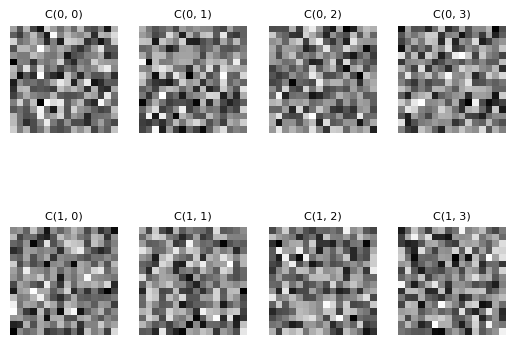

In [4]:
# weights on the cores
core_rows = 16
core_cols = 16
total_cores = 8
num_layers = 2
cores_per_layer = total_cores // num_layers

# initialize weights on all the cores
rngs = nnx.Rngs(params=1, activations=2, masks=3)
initializer = flax.nnx.nn.initializers.glorot_normal()
weights = initializer(rngs.params(), (num_layers, cores_per_layer, core_rows, core_cols))
print(weights.shape)

fig, ax = plt.subplots(weights.shape[0], weights.shape[1])

for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        ax[i, j].imshow(weights[i, j, ...], cmap='gray')
        ax[i, j].set_title(f"C{i, j}", fontsize = 8)
        ax[i, j].axis('off')

In [ ]:
# scrambling but keeping balance condition

class SimpleScramble(nnx.Module):
    def __init__(
        self,
        input_length: int,
        core_length: int,
        slot_length: int,
        avg_cores_per_chunk: int,
        rngs: nnx.Rngs,
    ):

    self.input_length = input_length
    self.core_length = core_length
    self.slot_length = slot_length
    self.avg_cores_per_chunk = avg_cores_per_chunk
    self.rngs = rngs
    
    self.signin

[[0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]]


NameError: name 'rngs' is not defined

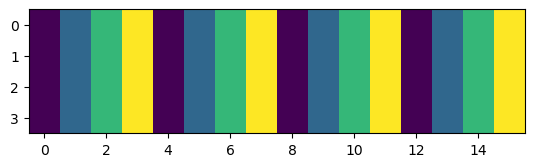

In [2]:
x_test = jnp.tile(jnp.array([0, 1, 2, 3]), 16)

plt.imshow(x_test.reshape(4, -1))

# makinf the core-wise permutation
p1 = jnp.eye(x_test.shape[0])
# plt.matshow(p1)
rand_perm = jax.random.permutation(rngs.params(), x_test.shape[0])
rand_perm_cores = jax.random.permutation(rngs.params(), 4)
p2 = jnp.eye(x_res.shape[0])
p2 = p2[rand_perm_cores]
print(rand_perm)
p1 = p1[rand_perm]
print(f"Corewise permutation")
plt.matshow(p1)
print(f"Slot-wise permutation")
plt.matshow(p2)

x_scr = jnp.einsum('ij,j->i', p1, x_test)
print(f"Scrambled inputs to slots")
plt.matshow(x_scr.reshape(4, -1))

x_res = x_scr.reshape(4, -1)
x_scr2 = jnp.einsum('ij,jk->ik', p2, x_res)
# x_scr2 = x_scr2.reshape(-1,)
print(f"Copy of inputs to slots, scrambled")
plt.matshow(x_scr2)

print(f"xpos - xneg")
plt.matshow((x_scr - x_scr2.flatten()).reshape(4, -1))

In [ ]:
def visualize_permutation_matrix(P):
    """
    Visualize a permutation matrix as a bipartite graph.
    
    Parameters:
    -----------
    P : numpy.ndarray
        A permutation matrix (n x n) with entries of 0s and 1s
    """
    n = P.shape[0]  # Size of the permutation matrix (assuming square)
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 12))
    
    # Set positions for left and right columns of dots
    left_x = 0.2
    right_x = 0.8
    y_positions = jnp.linspace(0.05, 0.95, n)
    
    # Plot dots for left column (input slots)
    left_points = []
    for i in range(n):
        left_points.append((left_x, y_positions[i]))
        ax.plot(left_x, y_positions[i], 'o', color='blue', markersize=6)
        ax.text(left_x - 0.05, y_positions[i], f"{i+1}", ha='right', va='center')
    
    # Plot dots for right column (output slots)
    right_points = []
    for i in range(n):
        right_points.append((right_x, y_positions[i]))
        ax.plot(right_x, y_positions[i], 'o', color='green', markersize=6)
        ax.text(right_x + 0.05, y_positions[i], f"{i+1}", ha='left', va='center')
    
    # Draw lines based on the permutation matrix
    for i in range(n):
        j = jnp.where(P[i] == 1)[0][0]  # Find the position of 1 in row i
        ax.plot([left_x, right_x], [y_positions[i], y_positions[j]], 
                '-', color='gray', alpha=0.7, linewidth=0.8)
    
    # Set plot limits and remove axes
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    
    # Add title and labels
    plt.title('Permutation Matrix Visualization')
    plt.text(left_x, 0.01, 'Input Slots', ha='center')
    plt.text(right_x, 0.01, 'Output Slots', ha='center')
    
    plt.tight_layout()
    return fig

fig = visualize_permutation_matrix(p1)
plt.show()

## Thinking in terms of modules

In [ ]:
# a single core
class Core